#                           使用SWinIR方法恢复图像对set5数据集进行测试

导入相关包

In [1]:
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
# from skimage.metrics import structural_similarity as ssim

实现显示图片函数

In [8]:
def show(image1,image2):

    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    
    # 水平拼接两张图像
    concatenated_image = np.hstack((image1, image2))

    # 显示拼接后的图像
    plt.imshow(concatenated_image)
    plt.axis('off')

    # 对第一张图像添加标注
    plt.text(image1.shape[1] // 2, image1.shape[0] + 30, 'Origin_Image ', color='red', fontsize=12, ha='center')

    # 对第二张图像添加标注
    plt.text(image1.shape[1] + image2.shape[1] // 2, image1.shape[0] + 30, 'SWinIR_Image', color='blue', fontsize=12, ha='center')
    

    plt.show()
    

# def bicubic(image):
#     scale_factor=4

#     # 进行 Bicubic 下采样
#     image = cv2.resize(image, None, fx=1/scale_factor, fy=1/scale_factor, interpolation=cv2.INTER_CUBIC)

#     # 返回处理后的图像
#     return image

定义Calculate SSIM函数

In [4]:
#更改图像通道顺序
def reorder_image(img, input_order='HWC'):
    if input_order not in ['HWC', 'CHW']:
        raise ValueError(f'Wrong input_order {input_order}. Supported input_orders are ' "'HWC' and 'CHW'")
    if len(img.shape) == 2:
        img = img[..., None]
    if input_order == 'CHW':
        img = img.transpose(1, 2, 0)
    return img

# 计算单通道图像的ssim
def _ssim(img1, img2):
    C1 = (0.01 * 255) ** 2
    C2 = (0.03 * 255) ** 2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1 ** 2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2 ** 2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

#计算ssim
def calculate_ssim(img1, img2, input_order='HWC'):

    assert img1.shape == img2.shape, (f'Image shapes are differnet: {img1.shape}, {img2.shape}.')
    if input_order not in ['HWC', 'CHW']:
        raise ValueError(f'Wrong input_order {input_order}. Supported input_orders are ' '"HWC" and "CHW"')
    img1 = reorder_image(img1, input_order=input_order)
    img2 = reorder_image(img2, input_order=input_order)
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    ssims = []
    for i in range(img1.shape[2]):
        ssims.append(_ssim(img1[..., i], img2[..., i]))
    return np.array(ssims).mean()

主函数

baby.png


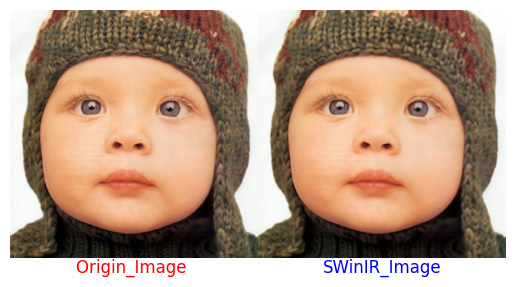

PSNR: 32.575010447251564
SSIM: 0.8754996770187775


bird.png


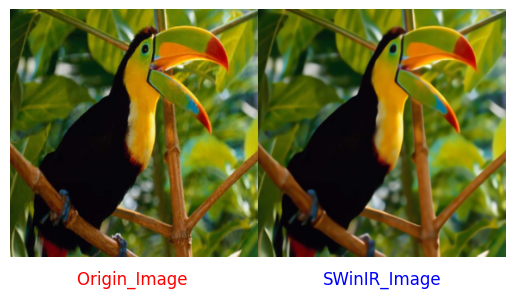

PSNR: 33.331696183255374
SSIM: 0.9357416741598193


butterfly.png


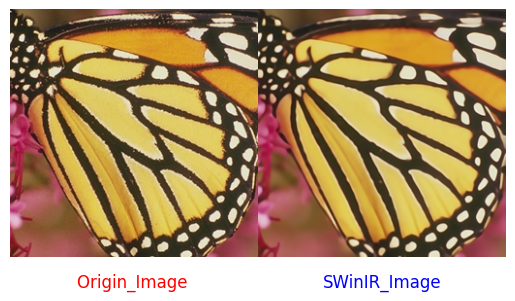

PSNR: 28.305769984922684
SSIM: 0.92187544892044


head.png


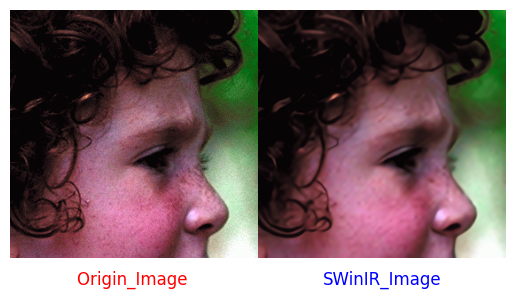

PSNR: 30.128507138765677
SSIM: 0.727722043359777


woman.png


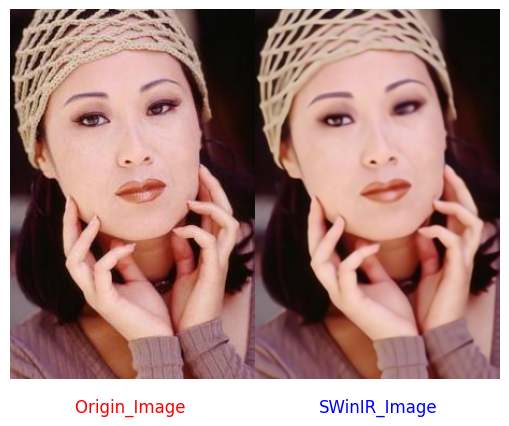

PSNR: 30.09779075413438
SSIM: 0.9166025177018685


Averge PSNR: 30.887754901665936
Averge SSIM: 0.8754882722321364


In [9]:
if __name__ == "__main__":

    origin_path ='test_data/set5'
    sr_path='test_data/set5_SwinIR'
    psnr_list = []
    ssim_list = []
    for file in os.listdir(origin_path):
        # 加载图像
        origin_filepath = os.path.join(origin_path, file)
        sr_filepath=os.path.join(sr_path,file)
        
        origin_image=cv2.imread(origin_filepath)
        sr_image=cv2.imread(sr_filepath)
#         sr_image=bicubic(sr_image_1)
        
        # 统一图像尺寸
        sr_image=cv2.resize(sr_image, (origin_image.shape[1], origin_image.shape[0]))
        print(file)
        
        show(origin_image,sr_image)
        # PSNR
        psnr = cv2.PSNR(origin_image, sr_image)
        psnr_list.append(psnr)
        # SSIM
        ssim_value= calculate_ssim(origin_image, sr_image)
        ssim_list.append(ssim_value)
        print("PSNR:", psnr)
        print("SSIM:", ssim_value)
        print('\n')
        
    print("Averge PSNR:",np.mean(psnr_list))
    print("Averge SSIM:",np.mean(ssim_list))